In [1]:
from timeit import default_timer
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import corner
import copy
import pandas as pd
%matplotlib inline

from bilby.core.prior import PriorDict, PowerLaw, Uniform, Sine, Cosine, DeltaFunction
from bilby.gw.conversion import bilby_to_lalsimulation_spins,  generate_component_spins, generate_component_masses
from pycbc.detector import Detector
from sifce import datatools, utils, population

In [2]:
prior_waves=dict(mass_ratio=PowerLaw(alpha=0, name='mass_ratio', minimum=0.125, maximum=1),
                mass_1= PowerLaw(alpha=-1, name='mass_1', minimum=10, maximum=80),
                a_1 = Uniform(name='a_1', minimum=0, maximum=0.99),
                a_2 = Uniform(name='a_2', minimum=0, maximum=0.99),
                tilt_1 = Sine(name='tilt_1'),
                tilt_2 = Sine(name='tilt_2'),
                phi_12 = Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic'),
                phi_jl = Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic'),
                luminosity_distance = PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$'),
                dec =  Cosine(name='dec'),
                ra =  Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic'),
                theta_jn =  Sine(name='theta_jn'),
                psi =  Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic'),
                phase =  Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic'),
                reference_frequency = DeltaFunction(20),
                )
PDict = PriorDict(dictionary=prior_waves)

In [4]:
samples = PDict.sample(1000)

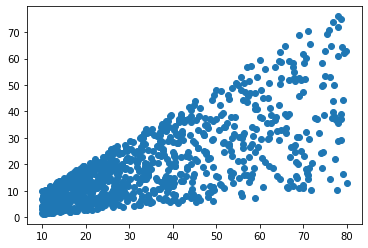

In [5]:
samples_df = pd.DataFrame(samples)
samples = generate_component_masses(samples)
samples = generate_component_spins(samples)
plt.scatter(samples['mass_1'], samples['mass_2'])


In [9]:
samples_df = pd.DataFrame(samples)

waveform_generation_labels = [
    "mass_1",
    "mass_2",
    "spin_1x",
    "spin_1y",
    "spin_1z",
    "spin_2x",
    "spin_2y",
    "spin_2z",
    "theta_jn",
    "phase",
]
detector_position_labels = [
    "ra",
    "dec",
    "psi",
]


delta_f = 1 / 8.0
f_start = 20
f_max = 512
approximant = "IMRPhenomXPHM"
end_time = 10000000


detectors = dict()
psds = dict()
for ifo in ['H1', 'L1', 'V1']:
    psds[ifo] = utils.read_psd_from_txt(
        f"o3_{ifo.lower()}.txt",
        f_min=f_start,
        f_max=f_max,
        delta_f=delta_f,
        basedir="/home/rudall/Projects/SIFCE",
        asd=True,
    )
    detectors[ifo] = Detector(ifo)

snr_means = []
    
samples_df.drop(columns=detector_position_labels) 
    
start = default_timer()
    
for idx, row in samples_df.iterrows():
    wf_params = row[waveform_generation_labels].to_dict()
    hp, hc = datatools.compute_hphc_fd(wf_params, approximant, delta_f=delta_f, f_start=f_start, f_max=f_max)
    
    sky_positions = PDict.sample_subset(keys=detector_position_labels,size=1000)
    scattered_snr_opt, scattered_snr_mf = datatools.sky_scatter_snr(
        sky_positions,
        dict(
            plus_template = hp,
            cross_template = hc,
            ),
        end_time=end_time,
        psd_dict=psds,
        detector_obj_dict=detectors,
        fmin=f_start,
        fmax=f_max
    )
    snr_means += [np.mean(scattered_snr_opt['net'])]
    
end = default_timer()
print(end-start)

samples_df.insert(len(samples_df.columns), 'snr_opt_mean', snr_means)

/home/rudall/Projects/SIFCE/sifce/sifce/datatools.py:380: RuntimeWarning: invalid value encountered in sqrt
  rho_opt_array = np.sqrt(temp_temp_wip)
/home/rudall/Projects/SIFCE/sifce/sifce/datatools.py:393: RuntimeWarning: overflow encountered in square
  rho_mf_net += rho_mf_array**2
/home/rudall/Projects/SIFCE/sifce/sifce/datatools.py:396: RuntimeWarning: invalid value encountered in sqrt
  rho_opt_dict["net"] = np.sqrt(rho_opt_net)


14.943691976000082


In [10]:
samples_df['total_mass'] = samples_df['mass_1'] + samples_df['mass_2']
samples_df['symmetric_mass_ratio'] = samples_df['mass_ratio'] / ((1 + samples_df['mass_ratio']) ** 2)
samples_df['chirp_mass'] = samples_df['symmetric_mass_ratio'] ** (0.6) * samples_df['total_mass']
samples_df_backup = copy.deepcopy(samples_df)
sub_params_list = ['chirp_mass','total_mass','mass_ratio','spin_1z','spin_2z']
testing_sub_df = samples_df[sub_params_list]
print(samples_df)

     mass_ratio     mass_1       a_1       a_2    tilt_1    tilt_2    phi_12  \
0      0.129251  16.294693  0.342113  0.542746  1.278465  0.711260  2.623116   
1      0.240342  30.943069  0.709188  0.412266  1.582524  0.814382  3.402229   
2      0.468639  20.845805  0.470505  0.018822  1.620111  2.297048  5.096909   
3      0.842764  52.880591  0.875641  0.577788  1.144502  2.195154  0.393243   
4      0.495261  39.560190  0.347145  0.043057  0.558405  1.103225  2.775366   
..          ...        ...       ...       ...       ...       ...       ...   
995    0.260170  71.280774  0.022657  0.269773  2.471968  2.518453  5.556585   
996    0.293269  68.802640  0.173778  0.525624  1.568542  2.039201  2.645362   
997    0.690345  59.333234  0.042596  0.784100  1.408895  1.816085  2.212238   
998    0.322479  11.980155  0.885972  0.392918  2.723760  1.113158  6.196483   
999    0.569899  12.990071  0.013154  0.265756  1.307134  2.403706  3.843896   

       phi_jl  luminosity_distance     

Text(0.5, 0.98, 'Sky Averaged SNR Parametric Dependence')

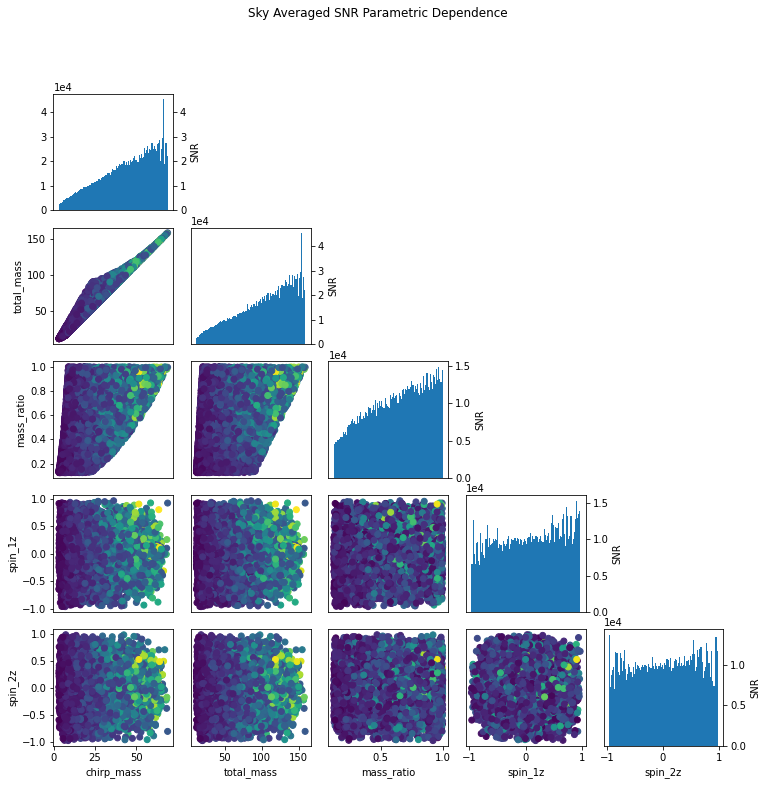

In [83]:
plt.close()

grid_dim = len(sub_params_list)
fig, axes = plt.subplots(
    grid_dim,
    grid_dim,
    #sharex=True,
    #sharey=True,
    figsize=(12,12),
    gridspec_kw=dict(
        wspace=0.15,
        hspace=0.15,
    )
)
for i in range(grid_dim):
    for j in range(grid_dim):
        if j > 0:
            axes[i,j].tick_params(left=False, labelleft=False)
        else:
            axes[i,j].set_ylabel(sub_params_list[i])
        if i < grid_dim-1:
            axes[i,j].tick_params(bottom=False, labelbottom=False)
        else:
            axes[i,j].set_xlabel(sub_params_list[j])
        if i<j:
            axes[i, j].axis('off')
        elif i == j:
            param = sub_params_list[i]
            samples_per_bin, hist_bins = np.histogram(
                samples_df[param].to_numpy(),
                bins=101
            )
            snr_weighting = copy.deepcopy(samples_df['snr_opt_mean']).to_numpy()
            
            # digitize is stupid
            bin_indices = np.digitize(samples_df[param].to_numpy(), hist_bins, right=True)
            bin_indices[np.nonzero(bin_indices == 0)] = 1
            bin_indices -= 1
            snr_weighting /= samples_per_bin[bin_indices]
            
            axes[i, j].hist(
                samples_df[param],
                weights=snr_weighting,
                bins=hist_bins
            )
            axes[i,j].tick_params(right=True, labelright=True)
            #axes[i,j].tick_params(bottom=True, labelbottom=True)
            axes[i,j].ticklabel_format(scilimits=(-3,3))
            axes[i,j].set_ylabel("SNR")
            axes[i,j].yaxis.set_label_position("right")
        else:
            param_1 = sub_params_list[j]
            param_2 = sub_params_list[i]
            
            param_1_array = copy.deepcopy(samples_df[param_1].to_numpy())
            param_2_array = copy.deepcopy(samples_df[param_2].to_numpy())
            snrs = copy.deepcopy(samples_df['snr_opt_mean']).to_numpy()
                        
            axes[i,j].scatter(param_1_array, param_2_array, c=snrs)

fig.suptitle("Sky Averaged SNR Parametric Dependence")

In [ ]:
    fig, axes = plt.subplots(
        grid_dim,
        grid_dim,
        #sharex=True,
        #sharey=True,
        figsize=(12,12),
        gridspec_kw=dict(
            wspace=0.15,
            hspace=0.15,
        )
    )
    for i in range(grid_dim):
        for j in range(grid_dim):
            if j > 0:
                axes[i,j].tick_params(left=False, labelleft=False)
            else:
                axes[i,j].set_ylabel(sub_params_list[i])
            if i < grid_dim-1:
                axes[i,j].tick_params(bottom=False, labelbottom=False)
            else:
                axes[i,j].set_xlabel(sub_params_list[j])
            if i<j:
                axes[i, j].axis('off')
            elif i == j:
                param = sub_params_list[i]
                samples_per_bin, hist_bins = np.histogram(
                    samples_df[param].to_numpy(),
                    bins=101
                )
                snr_weighting = copy.deepcopy(samples_df['snr_opt_mean']).to_numpy()
                
                # digitize is stupid
                bin_indices = np.digitize(samples_df[param].to_numpy(), hist_bins, right=True)
                bin_indices[np.nonzero(bin_indices == 0)] = 1
                bin_indices -= 1
                snr_weighting /= samples_per_bin[bin_indices]
                
                axes[i, j].hist(
                    samples_df[param],
                    weights=snr_weighting,
                    bins=hist_bins
                )
                axes[i,j].tick_params(right=True, labelright=True)
                #axes[i,j].tick_params(bottom=True, labelbottom=True)
                axes[i,j].ticklabel_format(scilimits=(-3,3))
                axes[i,j].set_ylabel("SNR")
                axes[i,j].yaxis.set_label_position("right")
            else:
                param_1 = sub_params_list[j]
                param_2 = sub_params_list[i]
                
                param_1_array = copy.deepcopy(samples_df[param_1].to_numpy())
                param_2_array = copy.deepcopy(samples_df[param_2].to_numpy())
                snrs = copy.deepcopy(samples_df['snr_opt_mean']).to_numpy()
                            
                axes[i,j].scatter(param_1_array, param_2_array, c=snrs)

    fig.suptitle("Sky Averaged SNR Parametric Dependence")